In [1]:
import pandas as pd
import glob
import os



In [3]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType

schema = StructType([
    StructField("name", StringType(), True),
    StructField("lat", DoubleType(), True),
    StructField("lon", DoubleType(), True),
    StructField("text", StringType(), True),
    StructField("date", StringType(), True),
    StructField("score", IntegerType(), True),
    StructField("keyword", StringType(), True),
    StructField("addr", StringType(), True),
    StructField("language", StringType(), True)
])

df = spark.read.csv('/home/ymusic7/metro_restaurants/combined.csv', header=False, schema=schema)


In [4]:
from pyspark.sql import functions as F
df_english = df.filter(F.col('language') == 'en')
df_english.show(5)


+--------------------+------------------+------------------+--------------------+-------------------+-----+-------------------+--------------------+--------+
|                name|               lat|               lon|                text|               date|score|            keyword|                addr|language|
+--------------------+------------------+------------------+--------------------+-------------------+-----+-------------------+--------------------+--------+
|        Sushi Avenue|33.864809699999995|       -84.0164532|This restaurant i...|2022-12-12 02:02:01|    5|japanese restaurant|2118 Scenic Hwy N...|      en|
|Volcano Steak & S...|        33.8837304|-84.73298129999999|5/5 because this ...|2024-07-06 22:24:10|    5|japanese restaurant|5750 Wendy Bagwel...|      en|
|        Sushi Avenue|33.864809699999995|       -84.0164532|Name has changed ...|2024-03-12 11:34:31|    5|japanese restaurant|2118 Scenic Hwy N...|      en|
|SAPPORO JAPANESE ...|        33.7214215|       -84.

In [4]:
# Count the number of reviews for each keyword
review_counts = df_english.groupBy("keyword").count()
review_counts.show()


+-------------------+------+
|            keyword| count|
+-------------------+------+
|japanese restaurant|211226|
| chinese restaurant|268833|
|         ON K2K 3M2|     1|
+-------------------+------+



In [6]:
df_filtered_keywords = df_english.filter(
    (F.col("keyword") == "chinese restaurant") | (F.col("keyword") == "japanese restaurant")
)
review_counts = df_filtered_keywords.groupBy("keyword").count()
review_counts.show()


+-------------------+------+
|            keyword| count|
+-------------------+------+
|japanese restaurant|211226|
| chinese restaurant|268833|
+-------------------+------+



In [7]:
# random sample to match to each kinds: 
# Minimum count between the two categories
min_count = review_counts.agg(F.min("count")).collect()[0][0]

# Sample to match the smaller count
df_chinese = df_filtered_keywords.filter(F.col("keyword") == "chinese restaurant").limit(min_count)
df_japanese = df_filtered_keywords.filter(F.col("keyword") == "japanese restaurant").limit(min_count)

# Combine datasets
df_balanced = df_chinese.union(df_japanese)

# Save balanced dataset
df_balanced.write.parquet("/home/ymusic7/metro_restaurants/balanced_reviews.parquet", mode="overwrite")


In [10]:
review_counts = df_balanced.groupBy("keyword").count()
review_counts.show()

+-------------------+------+
|            keyword| count|
+-------------------+------+
| chinese restaurant|211226|
|japanese restaurant|211226|
+-------------------+------+



In [11]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
import pyspark.sql.functions as F

# Load the balanced dataset
df_balanced = spark.read.parquet("/home/ymusic7/metro_restaurants/balanced_reviews.parquet")

# Convert text to lowercase
df_cleaned = df_balanced.withColumn('text', F.lower(F.col('text')))

# Tokenize the text
tokenizer = Tokenizer(inputCol='text', outputCol='words')
df_tokenized = tokenizer.transform(df_cleaned)

# Remove stopwords
stopwords = StopWordsRemover.loadDefaultStopWords("english")
remover = StopWordsRemover(inputCol='words', outputCol='filtered_words', stopWords=stopwords)
df_filtered = remover.transform(df_tokenized)

# View the cleaned and tokenized text
df_filtered.select('keyword', 'filtered_words').show(5, truncate=False)

# Save the preprocessed dataset for future use
df_filtered.write.parquet("/home/ymusic7/metro_restaurants/preprocessed_reviews.parquet", mode="overwrite")



+-------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|keyword            |filtered_words                                                                                                                                                                                                                                                    

Preprocessing completed and saved!


In [12]:
from pyspark.ml.feature import CountVectorizer

# Convert words into numerical features using CountVectorizer
vectorizer = CountVectorizer(inputCol='filtered_words', outputCol='features')
vectorized_model = vectorizer.fit(df_filtered)
df_vectorized = vectorized_model.transform(df_filtered)

# View the vectorized features
df_vectorized.select('keyword', 'features').show(5, truncate=False)



24/12/07 00:18:33 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/12/07 00:18:33 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
+-------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|keyword            |features                                                                                                                                                                              

In [6]:
from pyspark.ml.feature import HashingTF, IDF

# Generate term frequency vectors
hashingTF = HashingTF(inputCol='filtered_words', outputCol='raw_features', numFeatures=5000)
df_tf = hashingTF.transform(df_filtered)

# Apply IDF to scale term frequency vectors
idf = IDF(inputCol='raw_features', outputCol='features')
idf_model = idf.fit(df_tf)
df_tfidf = idf_model.transform(df_tf)

# View the TF-IDF features
df_tfidf.select('features').show(5, truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [9]:
from pyspark.ml.clustering import KMeans

# Define K-Means model
kmeans = KMeans(featuresCol='features', predictionCol='cluster', k=6, seed=42)
model = kmeans.fit(df_tfidf)

# Assign clusters to reviews
df_clusters = model.transform(df_tfidf)

# View clustered data
df_clusters.select('text', 'cluster').show(5, truncate=False)


+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|text                                                                                                                                                     

In [10]:
df_clusters.printSchema()


root
 |-- name: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- text: string (nullable = true)
 |-- date: string (nullable = true)
 |-- score: integer (nullable = true)
 |-- keyword: string (nullable = true)
 |-- addr: string (nullable = true)
 |-- language: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- raw_features: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- cluster: integer (nullable = false)



In [11]:
df_clusters.select('keyword').distinct().show()



+-------------------+
|            keyword|
+-------------------+
|japanese restaurant|
| chinese restaurant|
|         ON K2K 3M2|
+-------------------+



In [ ]:
df_japanese = df_clusters.filter(F.col('keyword') == 'japanese restaurant')
df_chinese = df_clusters.filter(F.col('keyword') == 'chinese restaurant')



In [29]:
# Group by cluster and sentiment for Japanese reviews
japanese_sentiment_distribution = df_japanese.groupBy("cluster", "sentiment").count()

# Group by cluster and sentiment for Chinese reviews
chinese_sentiment_distribution = df_chinese.groupBy("cluster", "sentiment").count()



In [30]:
# Convert to Pandas
japanese_sentiment_df = japanese_sentiment_distribution.toPandas()
chinese_sentiment_df = chinese_sentiment_distribution.toPandas()



In [ ]:
import seaborn as sns
print(sns.__version__)



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


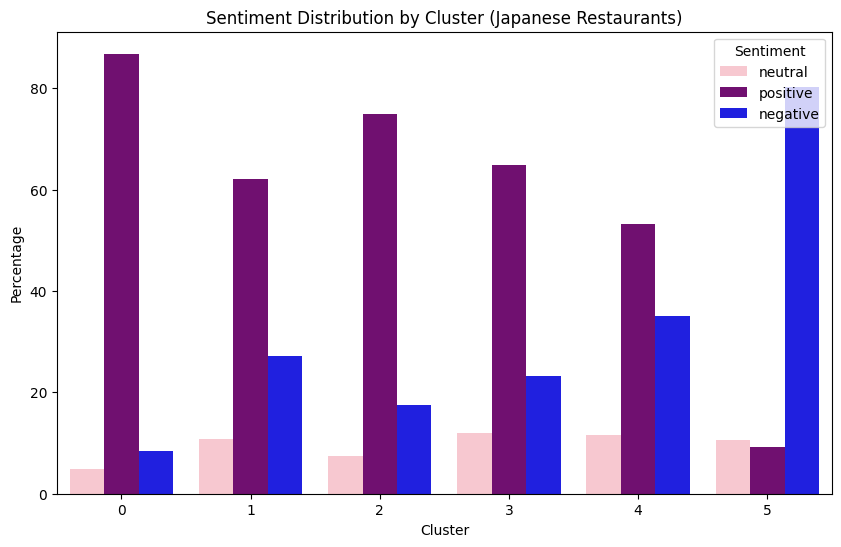

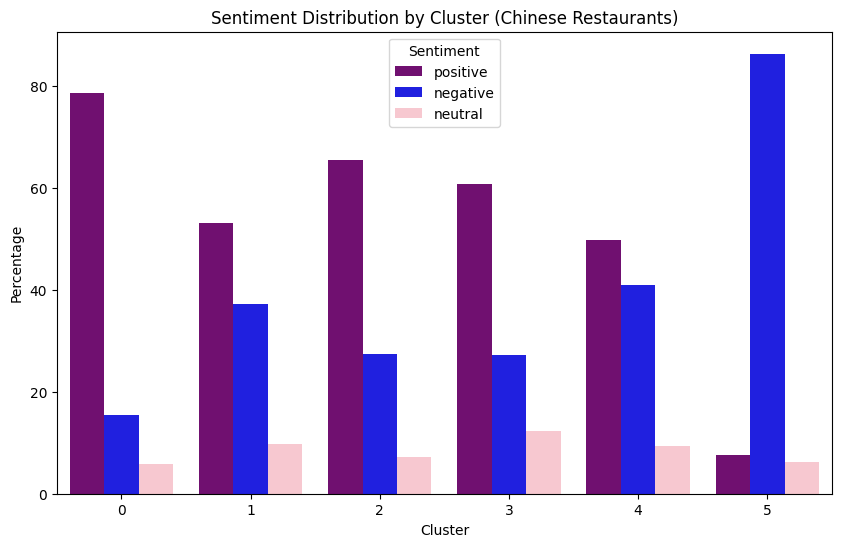

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert PySpark DataFrames to Pandas for Japanese and Chinese reviews
japanese_sentiment_df = df_japanese.groupBy("cluster", "sentiment").count().toPandas()
chinese_sentiment_df = df_chinese.groupBy("cluster", "sentiment").count().toPandas()

# Add a total column for percentage calculation
japanese_total = japanese_sentiment_df.groupby("cluster")["count"].sum().reset_index()
japanese_total.rename(columns={"count": "total"}, inplace=True)
japanese_sentiment_df = japanese_sentiment_df.merge(japanese_total, on="cluster")
japanese_sentiment_df["percentage"] = (japanese_sentiment_df["count"] / japanese_sentiment_df["total"]) * 100

chinese_total = chinese_sentiment_df.groupby("cluster")["count"].sum().reset_index()
chinese_total.rename(columns={"count": "total"}, inplace=True)
chinese_sentiment_df = chinese_sentiment_df.merge(chinese_total, on="cluster")
chinese_sentiment_df["percentage"] = (chinese_sentiment_df["count"] / chinese_sentiment_df["total"]) * 100

# Ensure consistent colors for sentiment categories
color_map = {"positive": "purple", "neutral": "pink", "negative": "blue"}

# Plot for Japanese restaurants
plt.figure(figsize=(10, 6))
sns.barplot(
    data=japanese_sentiment_df,
    x="cluster",
    y="percentage",
    hue="sentiment",
    palette=color_map
)
plt.title("Sentiment Distribution by Cluster (Japanese Restaurants)")
plt.xlabel("Cluster")
plt.ylabel("Percentage")
plt.legend(title="Sentiment")
plt.show()

# Plot for Chinese restaurants
plt.figure(figsize=(10, 6))
sns.barplot(
    data=chinese_sentiment_df,
    x="cluster",
    y="percentage",
    hue="sentiment",
    palette=color_map
)
plt.title("Sentiment Distribution by Cluster (Chinese Restaurants)")
plt.xlabel("Cluster")
plt.ylabel("Percentage")
plt.legend(title="Sentiment")
plt.show()



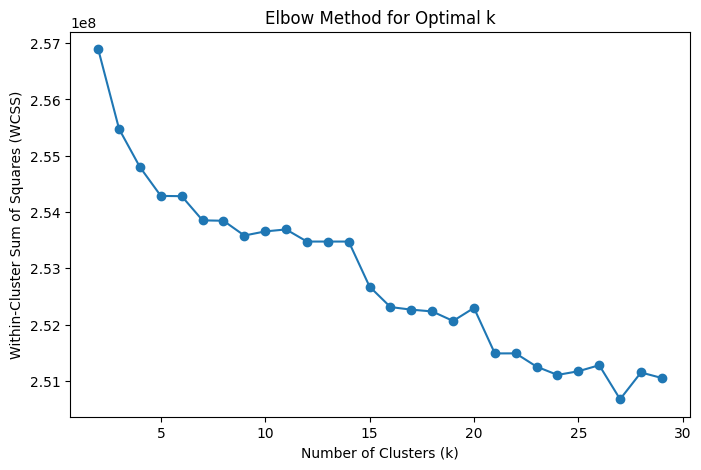

In [11]:
# k= 6 may not be suitable for this amount of reviews, using elbow method to find a better k value
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

wcss = []
for k in range(2, 30):  # Try different k values
    kmeans = KMeans(featuresCol="features", k=k, seed=42)
    model = kmeans.fit(df_tfidf)
    wcss.append(model.summary.trainingCost)

# Plot WCSS to find the "elbow"
plt.figure(figsize=(8, 5))
plt.plot(range(2, 30), wcss, marker="o")
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.show()


In [ ]:
#when i do the clustering training, should i separate Chinese and Japanese restaruant after tf idf 
#do cluserting separately or together cuz i think i did together and then seperate
#co-word?
# clustering based on TF-IDF, similar types of linguistic framing or similar consumer perceptions (e.g., clusters that reflect affordability, quality of service, etc.).


In [7]:
# Separate datasets for Chinese and Japanese restaurants
df_chinese = df_tfidf.filter(F.col('keyword') == 'chinese restaurant')
df_japanese = df_tfidf.filter(F.col('keyword') == 'japanese restaurant')

In [8]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Run clustering for Chinese restaurants
kmeans_chinese = KMeans(featuresCol="features", k=12, seed=42)
model_chinese = kmeans_chinese.fit(df_chinese)
df_chinese_clusters = model_chinese.transform(df_chinese)

# Run clustering for Japanese restaurants
kmeans_japanese = KMeans(featuresCol="features", k=12, seed=42)
model_japanese = kmeans_japanese.fit(df_japanese)
df_japanese_clusters = model_japanese.transform(df_japanese)



In [9]:
# Count the number of reviews in each cluster for Chinese restaurants
df_chinese_clusters.groupBy("prediction").count().show()

# Count the number of reviews in each cluster for Japanese restaurants
df_japanese_clusters.groupBy("prediction").count().show()


+----------+------+
|prediction| count|
+----------+------+
|         1|   577|
|         6|   518|
|         3|  4730|
|         5| 36059|
|         9|  1260|
|         4| 15264|
|         8|  5013|
|         7|  7114|
|        10|   720|
|        11|  3968|
|         2| 33628|
|         0|159982|
+----------+------+



+----------+------+
|prediction| count|
+----------+------+
|         1| 45485|
|         6| 10385|
|         3| 11303|
|         5| 18604|
|         9|  3025|
|         7|  4635|
|        10|  1489|
|        11|   783|
|         0|115513|
|         4|     2|
|         8|     1|
|         2|     1|
+----------+------+



In [11]:
from pyspark.sql.functions import abs, mean, col, first, struct

# Calculate average score for each cluster
average_scores = df_chinese_clusters.groupBy("prediction").agg(mean("score").alias("avg_score"))

# Join clusters with their average scores
df_chinese_with_avg = df_chinese_clusters.join(average_scores, on="prediction")

# Find reviews closest to the average score for each cluster
representative_reviews_chinese = df_chinese_with_avg.withColumn(
    "score_diff", abs(col("score") - col("avg_score"))
).groupBy("prediction").agg(
    first(struct("score_diff", "text")).alias("closest_review")
).select(
    col("prediction"),
    col("closest_review.text").alias("representative_review")
)

# Show representative reviews
representative_reviews_chinese.show(truncate=False)



+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [12]:
from pyspark.sql.functions import abs, mean, col, first, struct, lit

# Calculate average score for each cluster
average_scores_japanese = df_japanese_clusters.groupBy("prediction").agg(mean("score").alias("avg_score"))

# Join clusters with their average scores
df_japanese_with_avg = df_japanese_clusters.join(average_scores_japanese, on="prediction")

# Find reviews closest to the average score for each cluster
representative_reviews_japanese = df_japanese_with_avg.withColumn(
    "score_diff", abs(col("score") - col("avg_score"))
).groupBy("prediction").agg(
    first(struct("score_diff", "text")).alias("closest_review")
).select(
    col("prediction"),
    col("closest_review.text").alias("representative_review")
)

# Show representative reviews for Japanese clusters
representative_reviews_japanese.show(truncate=False)


+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [13]:
from pyspark.ml.linalg import DenseVector
from pyspark.sql.functions import col, udf
from pyspark.sql.types import FloatType
import numpy as np

# compute cosine similarity
def cosine_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    return float(dot_product / (norm_v1 * norm_v2)) if norm_v1 != 0 and norm_v2 != 0 else 0.0

# Register the function as a UDF
cosine_similarity_udf = udf(lambda features, centroid: cosine_similarity(features.toArray(), centroid.toArray()), FloatType())

# Get cluster centroids
df_chinese_centroids = spark.createDataFrame(
    [(float(i), DenseVector(center)) for i, center in enumerate(model_chinese.clusterCenters())],
    ["prediction", "centroid"]
)

# Join clusters with their centroids
df_chinese_with_centroids = df_chinese_clusters.join(df_chinese_centroids, on="prediction")

# Compute cosine similarity for each review in Chinese clusters
df_chinese_with_similarity = df_chinese_with_centroids.withColumn(
    "cosine_similarity",
    cosine_similarity_udf(col("features"), col("centroid"))
)

# Get the most representative review for each cluster
representative_reviews_chinese = df_chinese_with_similarity.groupBy("prediction").agg(
    F.first(F.struct("cosine_similarity", "text")).alias("closest_review")
).select(
    col("prediction"),
    col("closest_review.text").alias("representative_review")
)

# Show representative reviews for Chinese clusters
representative_reviews_chinese.show(truncate=False)


+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [15]:
from pyspark.ml.linalg import DenseVector
from pyspark.sql.functions import col, udf
from pyspark.sql.types import FloatType
import numpy as np

#function to compute cosine similarity (already defined for Chinese)
cosine_similarity_udf = udf(
    lambda features, centroid: cosine_similarity(features.toArray(), centroid.toArray()), 
    FloatType()
)

# Get cluster centroids for Japanese clusters
df_japanese_centroids = spark.createDataFrame(
    [(float(i), DenseVector(center)) for i, center in enumerate(model_japanese.clusterCenters())],
    ["prediction", "centroid"]
)

# Join clusters with their centroids for Japanese clusters
df_japanese_with_centroids = df_japanese_clusters.join(df_japanese_centroids, on="prediction")

# Compute cosine similarity for each review in Japanese clusters
df_japanese_with_similarity = df_japanese_with_centroids.withColumn(
    "cosine_similarity",
    cosine_similarity_udf(col("features"), col("centroid"))
)

# Get the most representative review for each cluster in Japanese clusters
representative_reviews_japanese = df_japanese_with_similarity.groupBy("prediction").agg(
    F.first(F.struct("cosine_similarity", "text")).alias("closest_review")
).select(
    col("prediction"),
    col("closest_review.text").alias("representative_review")
)

# Show representative reviews for Japanese clusters
representative_reviews_japanese.show(truncate=False)


+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [16]:
df_chinese_clusters.orderBy("text").show()


+--------------------+------------------+------------+--------------------+-------------------+-----+------------------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+----------+
|                name|               lat|         lon|                text|               date|score|           keyword|                addr|language|               words|      filtered_words|        raw_features|            features|prediction|
+--------------------+------------------+------------+--------------------+-------------------+-----+------------------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+----------+
|           Fresh Wok|        34.4250625|-117.3266261|! ! best dr.peppe...|2019-01-12 03:26:53|    4|chinese restaurant|15461 Main St #20...|      en|[!, !, best, dr.p...|[!, !, best, dr.p...|(5000,[55,106,157...|(5000,[55,106,157...|         0|
|Mandarin Lotus 